In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
import torch.nn.functional as F
import sys
np.random.seed(42)
import os
import pickle
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
parent_dir = os.path.abspath("../../")
sys.path.append(parent_dir)
parent_dir = os.path.abspath("../../utils/")
sys.path.append(parent_dir)
from pathlib import Path
from attention_visualisation import run_attention_dashboard, run_model_dashboard, run_neuron_dashboard

## Analysis

$\phi(\boldsymbol{u})$ is a random feature map for $\boldsymbol{u} \in \mathbb{R}^d$. For $\boldsymbol{Q'}, \boldsymbol{K'} \in \mathbb{R}^{L \times r}$ with rows given as  $\phi(\boldsymbol{q_i}^T)^T$ and $\phi(\boldsymbol{k_i}^T)^T$ respectively, leads to the more efficient attention mechanism of the form:
 $$
\begin{aligned}
  &\mathrm{Att}_{\!\leftrightarrow}(\mathbf{Q},\mathbf{K},\mathbf{V})
   = \hat{\mathbf{D}}^{-1}\bigl(\mathbf{Q}'((\mathbf{K}')^{\!\top}\mathbf{V})\bigr),
  &
  &\hat{\mathbf{D}}
   = \operatorname{diag}\!\bigl(\mathbf{Q}'((\mathbf{K}')^{\!\top}\mathbf{1}_L)\bigr).
\end{aligned}
$$

In the paper, they choose: 
$$\phi(\mathbf{x}) = \frac{h(\mathbf{x})}{\sqrt{m}} \left(f_1(\omega_1^T \mathbf{x}), \dots, f_1(\omega_m^T \mathbf{x}), ..., f_l(\omega_1^T \mathbf{x}), ..., f_l(\omega_m^T \mathbf{x})\right)$$

Here are 3 possible combinations to try:
1. $$\hat{SM_{m}}^{trig} (\mathbf{x}, \mathbf{y}) := h(x) = exp\left(\frac{\|\mathbf{x}\|^2}{2}\right), l=2, f_1 = sin, f_2 = cos$$
2. $$\hat{SM_{m}}^{+} (\mathbf{x}, \mathbf{y}) := h(x) = exp\left(-\frac{\|\mathbf{x}\|^2}{2}\right), l=1, f_1 = exp$$
3. $$\hat{SM_{m}}^{hyp+} (\mathbf{x}, \mathbf{y}) := h(x) = \frac{1}{\sqrt{2}}exp\left(-\frac{\|\mathbf{x}\|^2}{2}\right), l=2, f_1 = exp(u), f_2 = exp(-u)$$


How to choose $w_i$'s such that it is orthogonal:
We want to choose different random samples $\omega_1,...,\omega_m$ such that they come from $D \sim \mathcal{N}(0, \mathbf{I_d})$. We can use the Gram-Schmidt orthogonalisation to generate these. 


In [61]:
import numpy as np

d = 512
L = 140
m = 512

def random_feature_map(omegas, x, kernel_type="trig"):
    if kernel_type == "trig":
        num = np.exp(np.linalg.norm(x)**2 / 2) / np.sqrt(omegas.shape[0])
        ws =  omegas @ x
        f1, f2 = np.sin(ws), np.cos(ws)
        return num * np.concatenate([f1, f2])
    elif kernel_type == "+":
        num = np.exp(-np.linalg.norm(x)**2 / 2) / np.sqrt(omegas.shape[0])
        ws = omegas @ x
        f1 = np.exp(ws)
        return num * f1
    elif kernel_type == "hyp":
        num = np.exp(-np.linalg.norm(x)**2 / 2) / np.sqrt(2 * omegas.shape[0])
        ws = omegas @ x
        f1, f2 = np.exp(ws), np.exp(-ws)
        return num * np.concatenate([f1, f2])
    else:
        raise ValueError(f"Unknown kernel type: {kernel_type}")
    

In [62]:
query = np.random.normal(size=(L, d))
key = np.random.normal(size=(L, d))
value = np.random.normal(size=(L, d))
omegas = generate_orthogonal_random_vectors(m, d, 'multivariate_normal')
new_query = np.zeros((L, m))
new_key = np.zeros((L, m))

for i in range(L):
    new_query[i] = random_feature_map(omegas, query[i], kernel_type="+")
    new_key[i] = random_feature_map(omegas, key[i], kernel_type="+")

In [63]:
C = np.column_stack([value, np.ones((L, 1))])
buf_1 = new_key.T @ C
buf_2 = new_query @ buf_1
buf_3 = buf_2[:, :-1]
buf_4 = buf_2[:, -1]
ans = np.linalg.inv(np.diag((buf_4))) @ buf_3

In [66]:
attn = query @ key.T / (d ** 0.5)
attn = F.softmax(torch.tensor(attn), dim=-1)
attn = attn @ value

In [67]:
torch.max(attn - ans)

tensor(5.5593, dtype=torch.float64)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def gram_schmidt(vectors):
    """
    Apply Gram-Schmidt orthogonalization to a set of vectors.
    
    Args:
        vectors: numpy array of shape (m, n) where m is number of vectors
                and n is the dimension of each vector
    
    Returns:
        orthogonal_vectors: numpy array of orthogonalized vectors
    """
    vectors = vectors.copy().astype(float)
    m, n = vectors.shape
    
    for i in range(m):
        # Normalize the current vector
        vectors[i] = vectors[i] / np.linalg.norm(vectors[i])
        
        # Subtract projections onto previous vectors
        for j in range(i + 1, m):
            projection = np.dot(vectors[j], vectors[i]) * vectors[i]
            vectors[j] = vectors[j] - projection
    
    return vectors

def generate_random_vectors_gaussian(m, n, mean=0, std=1):
    """Generate m random vectors from Gaussian distribution."""
    return np.random.normal(mean, std, (m, n))

def generate_random_vectors_uniform(m, n, low=-1, high=1):
    """Generate m random vectors from uniform distribution."""
    return np.random.uniform(low, high, (m, n))

def generate_random_vectors_multivariate_normal(m, n, mean=None, cov=None):
    """Generate m random vectors from multivariate normal distribution."""
    if mean is None:
        mean = np.zeros(n)
    if cov is None:
        cov = np.eye(n)
    
    return np.random.multivariate_normal(mean, cov, m)

def generate_orthogonal_random_vectors(m, n, distribution='gaussian', **kwargs):
    """
    Generate m orthogonal random vectors of dimension n.
    
    Args:
        m: number of vectors
        n: dimension of each vector
        distribution: 'gaussian', 'uniform', or 'multivariate_normal'
        **kwargs: additional parameters for distribution
    
    Returns:
        orthogonal_vectors: numpy array of orthogonalized random vectors
    """
    if m > n:
        raise ValueError(f"Cannot generate {m} orthogonal vectors in {n}D space")
    
    if distribution == 'gaussian':
        vectors = generate_random_vectors_gaussian(m, n, **kwargs)
    elif distribution == 'uniform':
        vectors = generate_random_vectors_uniform(m, n, **kwargs)
    elif distribution == 'multivariate_normal':
        vectors = generate_random_vectors_multivariate_normal(m, n, **kwargs)
    else:
        raise ValueError("Distribution must be 'gaussian', 'uniform', or 'multivariate_normal'")
    
    return gram_schmidt(vectors)

## Results Visualisation

### Random Token Experiments

In [5]:
base_path = Path("experiments")
train_losses = pd.DataFrame()
val_losses = pd.DataFrame()
sentences = {}
exp_string = lambda x: f"hindi_model_16_256_2048_2_2_1_3_{x}"
for exp in [0, 2, 4, 8]:
    spec_string = exp_string(exp)
    # sentences = pd.read_csv(base_path / f"{spec_string}_sentences.txt", header=None, nrows=300)
    train_loss = pd.read_csv(base_path / f"{spec_string}_train_loss.txt", header=None, nrows=300)
    val_loss = pd.read_csv(base_path / f"{spec_string}_val_loss.txt", header=None, nrows=300)
    train_loss['random_token'] = exp
    val_loss['random_token'] = exp

    train_losses = pd.concat([train_losses, train_loss], ignore_index=True)
    val_losses = pd.concat([val_losses, val_loss], ignore_index=True)


In [6]:
# Rename the columns
train_losses.columns = ['loss_value', 'perplexity', 'accuracy', 'random_token']
train_losses['loss_value'] = train_losses['loss_value'].str.replace('(', '').astype(float)
train_losses['perplexity'] = train_losses['perplexity'].str.extract(r'float64\(([^)]+)\)').astype(float)
train_losses['accuracy'] = train_losses['accuracy'].str.replace(')', '').astype(float)

val_losses.columns = ['loss_value', 'perplexity', 'accuracy', 'random_token']
val_losses['loss_value'] = val_losses['loss_value'].str.replace('(', '').astype(float)
val_losses['perplexity'] = val_losses['perplexity'].str.extract(r'float64\(([^)]+)\)').astype(float)
val_losses['accuracy'] = val_losses['accuracy'].str.replace(')', '').astype(float)

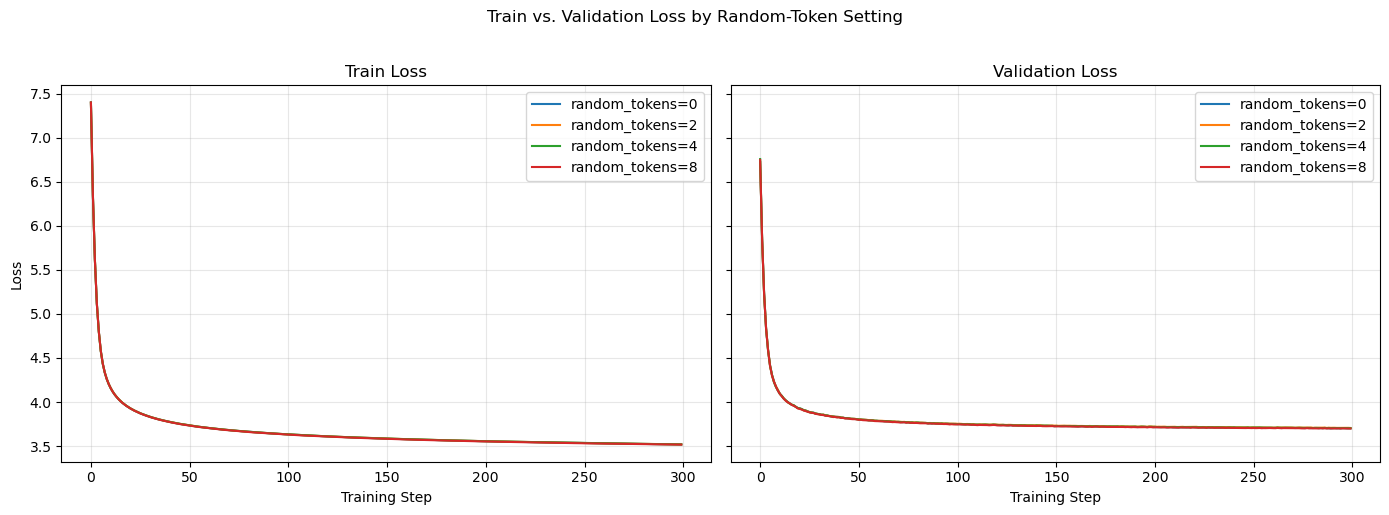

In [7]:
import matplotlib.pyplot as plt
import numpy as np
exp_values = sorted(train_losses['random_token'].unique())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=True)
# -------- Train Loss --------
ax = axes[0]
for exp in exp_values:
    data = train_losses[train_losses['random_token'] == exp]
    ax.plot(np.arange(len(data['loss_value'])),
            data['loss_value'],
            label=f'random_tokens={exp}')
ax.set_title('Train Loss')
ax.set_xlabel('Training Step')
ax.set_ylabel('Loss')
ax.grid(True, alpha=0.3)
ax.legend()

# -------- Validation Loss --------
ax = axes[1]
for exp in exp_values:
    data = val_losses[val_losses['random_token'] == exp]
    ax.plot(np.arange(len(data['loss_value'])),
            data['loss_value'],
            label=f'random_tokens={exp}')
ax.set_title('Validation Loss')
ax.set_xlabel('Training Step')
ax.grid(True, alpha=0.3)
ax.legend()
plt.suptitle('Train vs. Validation Loss by Random-Token Setting', y=1.02)
plt.tight_layout()
plt.show()

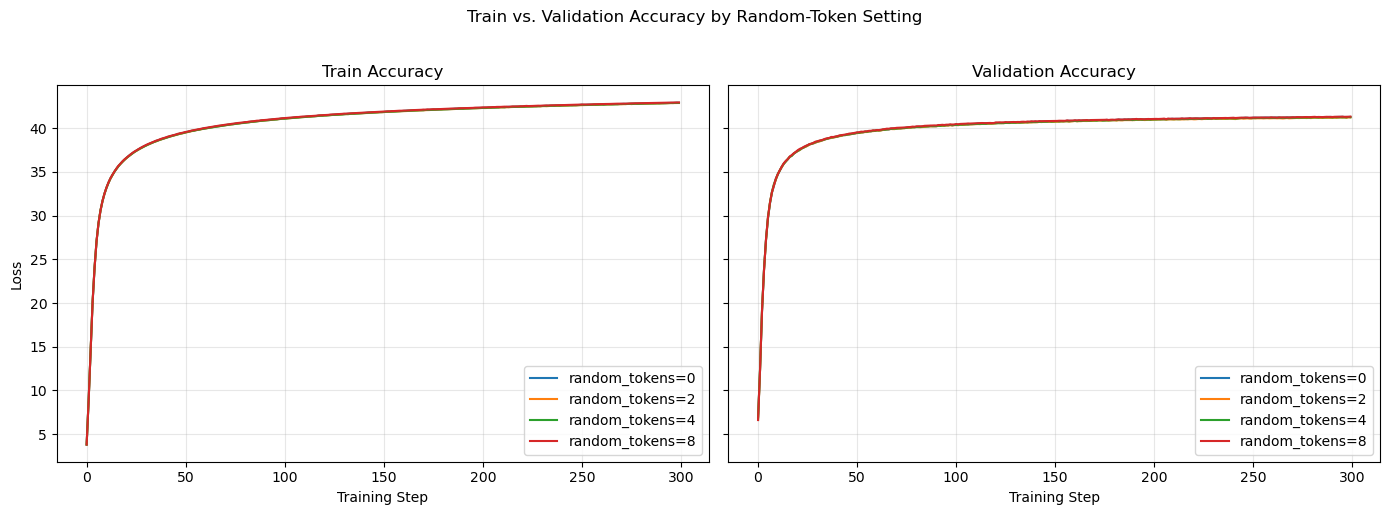

In [8]:
import matplotlib.pyplot as plt
import numpy as np
exp_values = sorted(train_losses['random_token'].unique())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=True)

# -------- Train Loss --------
ax = axes[0]
for exp in exp_values:
    data = train_losses[train_losses['random_token'] == exp]
    ax.plot(np.arange(len(data['accuracy'])),
            data['accuracy'],
            label=f'random_tokens={exp}')
ax.set_title('Train Accuracy')
ax.set_xlabel('Training Step')
ax.set_ylabel('Loss')
ax.grid(True, alpha=0.3)
ax.legend()

# -------- Validation Loss --------
ax = axes[1]
for exp in exp_values:
    data = val_losses[val_losses['random_token'] == exp]
    ax.plot(np.arange(len(data['accuracy'])),
            data['accuracy'],
            label=f'random_tokens={exp}')
ax.set_title('Validation Accuracy')
ax.set_xlabel('Training Step')
# sharey=True so no need to set ylabel again
ax.grid(True, alpha=0.3)
ax.legend()

plt.suptitle('Train vs. Validation Accuracy by Random-Token Setting', y=1.02)
plt.tight_layout()
plt.show()


### Window Size Experiments

In [ ]:
# 1,3,8, 1,5,8, 1,7,8, 1


In [10]:
base_path = Path("experiments")
train_losses = pd.DataFrame()
val_losses = pd.DataFrame()
sentences = {}
exp_string = lambda x: f"hindi_model_16_256_2048_2_2_1_{x}_8"
for exp in [3, 5, 7, 9, 11]:
    spec_string = exp_string(exp)
    # sentences = pd.read_csv(base_path / f"{spec_string}_sentences.txt", header=None, nrows=300)
    train_loss = pd.read_csv(base_path / f"{spec_string}_train_loss.txt", header=None, nrows=300)
    val_loss = pd.read_csv(base_path / f"{spec_string}_val_loss.txt", header=None, nrows=300)
    train_loss['window'] = exp
    val_loss['window'] = exp

    train_losses = pd.concat([train_losses, train_loss], ignore_index=True)
    val_losses = pd.concat([val_losses, val_loss], ignore_index=True)


In [13]:
# Rename the columns
train_losses.columns = ['loss_value', 'perplexity', 'accuracy', 'window']
train_losses['loss_value'] = train_losses['loss_value'].str.replace('(', '').astype(float)
train_losses['perplexity'] = train_losses['perplexity'].str.extract(r'float64\(([^)]+)\)').astype(float)
train_losses['accuracy'] = train_losses['accuracy'].str.replace(')', '').astype(float)

val_losses.columns = ['loss_value', 'perplexity', 'accuracy', 'window']
val_losses['loss_value'] = val_losses['loss_value'].str.replace('(', '').astype(float)
val_losses['perplexity'] = val_losses['perplexity'].str.extract(r'float64\(([^)]+)\)').astype(float)
val_losses['accuracy'] = val_losses['accuracy'].str.replace(')', '').astype(float)

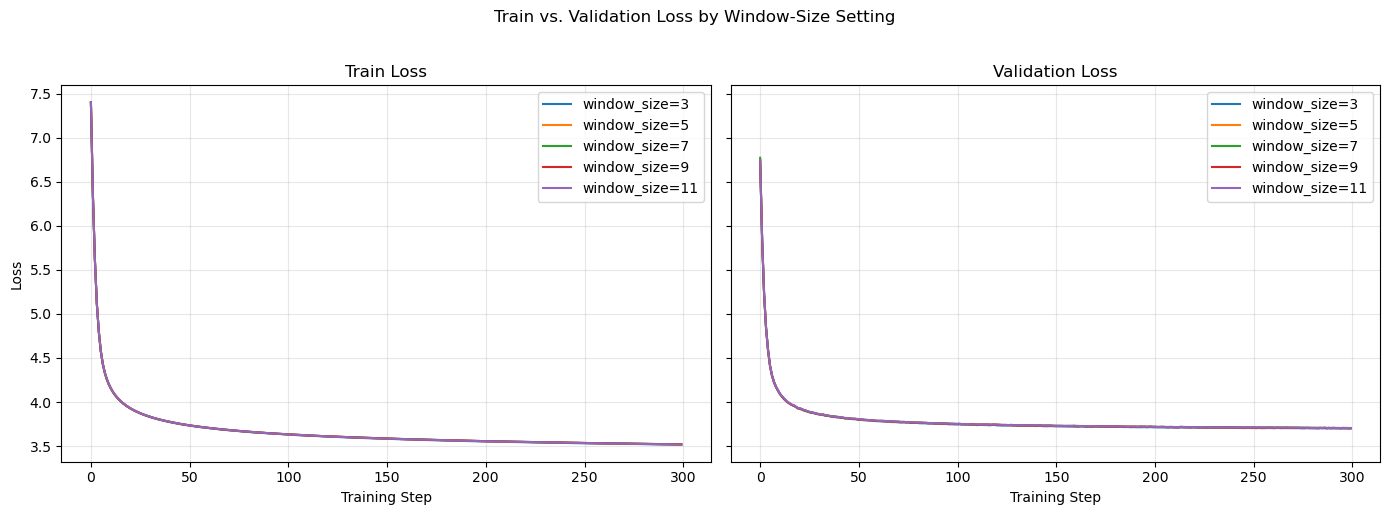

In [17]:
import matplotlib.pyplot as plt
import numpy as np
exp_values = sorted(train_losses['window'].unique())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=True)
# -------- Train Loss --------
ax = axes[0]
for exp in exp_values:
    data = train_losses[train_losses['window'] == exp]
    ax.plot(np.arange(len(data['loss_value'])),
            data['loss_value'],
            label=f'window_size={exp}')
ax.set_title('Train Loss')
ax.set_xlabel('Training Step')
ax.set_ylabel('Loss')
ax.grid(True, alpha=0.3)
ax.legend()

# -------- Validation Loss --------
ax = axes[1]
for exp in exp_values:
    data = val_losses[val_losses['window'] == exp]
    ax.plot(np.arange(len(data['loss_value'])),
            data['loss_value'],
            label=f'window_size={exp}')
ax.set_title('Validation Loss')
ax.set_xlabel('Training Step')
ax.grid(True, alpha=0.3)
ax.legend()
plt.suptitle('Train vs. Validation Loss by Window-Size Setting', y=1.02)
plt.tight_layout()
plt.show()

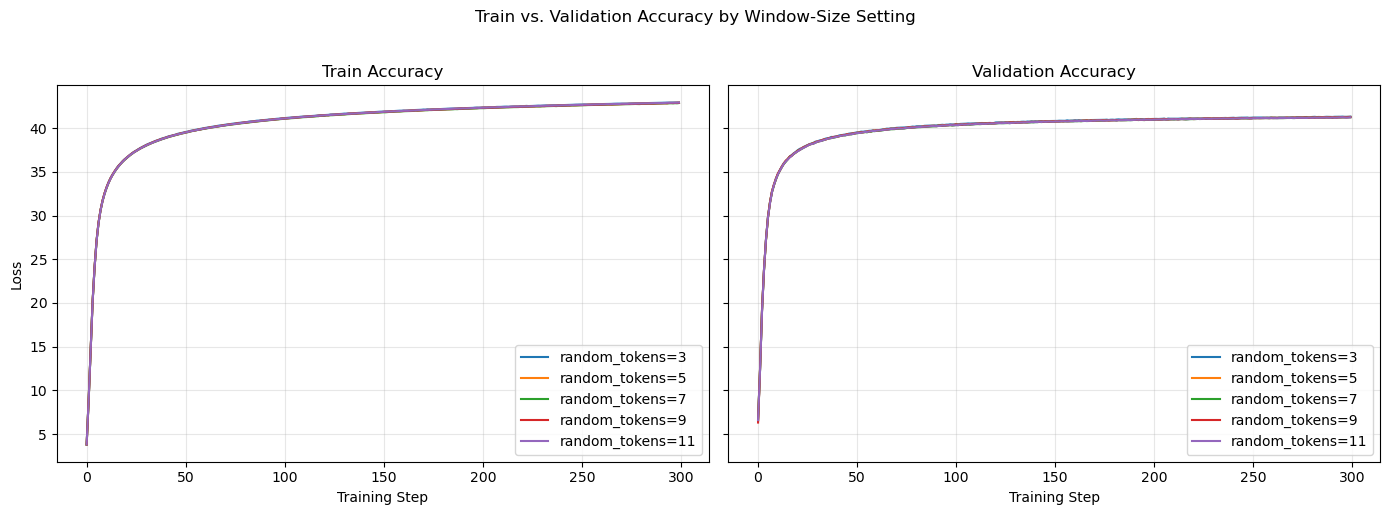

In [18]:
import matplotlib.pyplot as plt
import numpy as np
exp_values = sorted(train_losses['window'].unique())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=True)

# -------- Train Loss --------
ax = axes[0]
for exp in exp_values:
    data = train_losses[train_losses['window'] == exp]
    ax.plot(np.arange(len(data['accuracy'])),
            data['accuracy'],
            label=f'random_tokens={exp}')
ax.set_title('Train Accuracy')
ax.set_xlabel('Training Step')
ax.set_ylabel('Loss')
ax.grid(True, alpha=0.3)
ax.legend()

# -------- Validation Loss --------
ax = axes[1]
for exp in exp_values:
    data = val_losses[val_losses['window'] == exp]
    ax.plot(np.arange(len(data['accuracy'])),
            data['accuracy'],
            label=f'random_tokens={exp}')
ax.set_title('Validation Accuracy')
ax.set_xlabel('Training Step')
# sharey=True so no need to set ylabel again
ax.grid(True, alpha=0.3)
ax.legend()

plt.suptitle('Train vs. Validation Accuracy by Window-Size Setting', y=1.02)
plt.tight_layout()
plt.show()


### Global Token Experiments

In [19]:
base_path = Path("experiments")
train_losses = pd.DataFrame()
val_losses = pd.DataFrame()
sentences = {}
exp_string = lambda x: f"hindi_model_16_256_2048_2_2_{x}_3_8"
for exp in [0, 2, 4, 8, 16]:
    spec_string = exp_string(exp)
    # sentences = pd.read_csv(base_path / f"{spec_string}_sentences.txt", header=None, nrows=300)
    train_loss = pd.read_csv(base_path / f"{spec_string}_train_loss.txt", header=None, nrows=300)
    val_loss = pd.read_csv(base_path / f"{spec_string}_val_loss.txt", header=None, nrows=300)
    train_loss['global'] = exp
    val_loss['global'] = exp

    train_losses = pd.concat([train_losses, train_loss], ignore_index=True)
    val_losses = pd.concat([val_losses, val_loss], ignore_index=True)


In [20]:
# Rename the columns
train_losses.columns = ['loss_value', 'perplexity', 'accuracy', 'global']
train_losses['loss_value'] = train_losses['loss_value'].str.replace('(', '').astype(float)
train_losses['perplexity'] = train_losses['perplexity'].str.extract(r'float64\(([^)]+)\)').astype(float)
train_losses['accuracy'] = train_losses['accuracy'].str.replace(')', '').astype(float)

val_losses.columns = ['loss_value', 'perplexity', 'accuracy', 'global']
val_losses['loss_value'] = val_losses['loss_value'].str.replace('(', '').astype(float)
val_losses['perplexity'] = val_losses['perplexity'].str.extract(r'float64\(([^)]+)\)').astype(float)
val_losses['accuracy'] = val_losses['accuracy'].str.replace(')', '').astype(float)

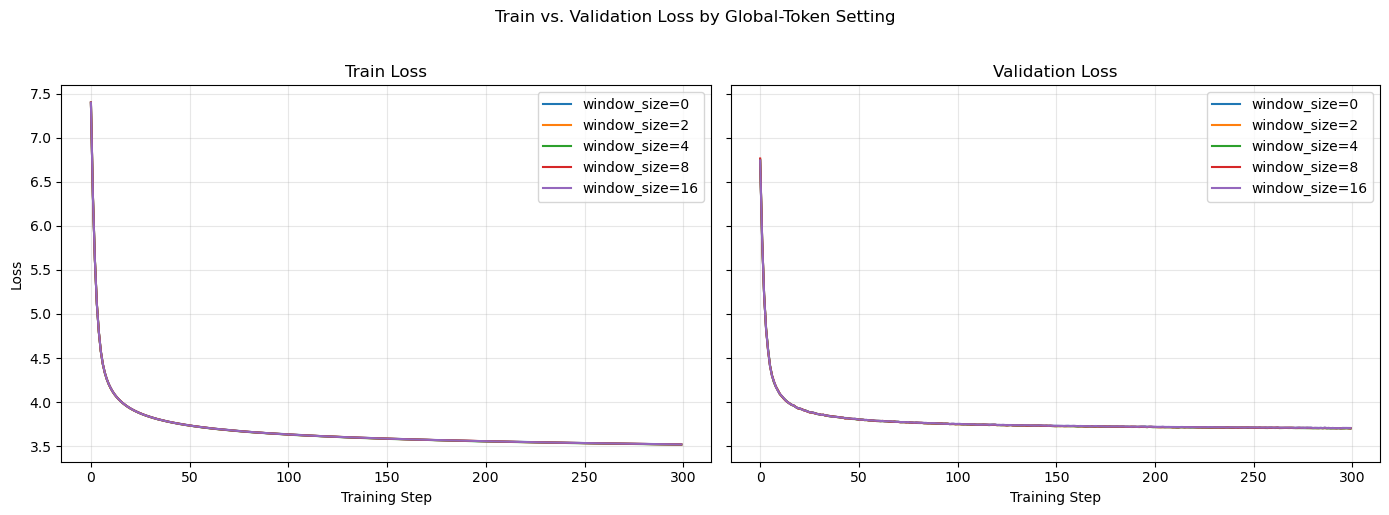

In [21]:
import matplotlib.pyplot as plt
import numpy as np
exp_values = sorted(train_losses['global'].unique())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=True)
# -------- Train Loss --------
ax = axes[0]
for exp in exp_values:
    data = train_losses[train_losses['global'] == exp]
    ax.plot(np.arange(len(data['loss_value'])),
            data['loss_value'],
            label=f'window_size={exp}')
ax.set_title('Train Loss')
ax.set_xlabel('Training Step')
ax.set_ylabel('Loss')
ax.grid(True, alpha=0.3)
ax.legend()

# -------- Validation Loss --------
ax = axes[1]
for exp in exp_values:
    data = val_losses[val_losses['global'] == exp]
    ax.plot(np.arange(len(data['loss_value'])),
            data['loss_value'],
            label=f'window_size={exp}')
ax.set_title('Validation Loss')
ax.set_xlabel('Training Step')
ax.grid(True, alpha=0.3)
ax.legend()
plt.suptitle('Train vs. Validation Loss by Global-Token Setting', y=1.02)
plt.tight_layout()
plt.show()

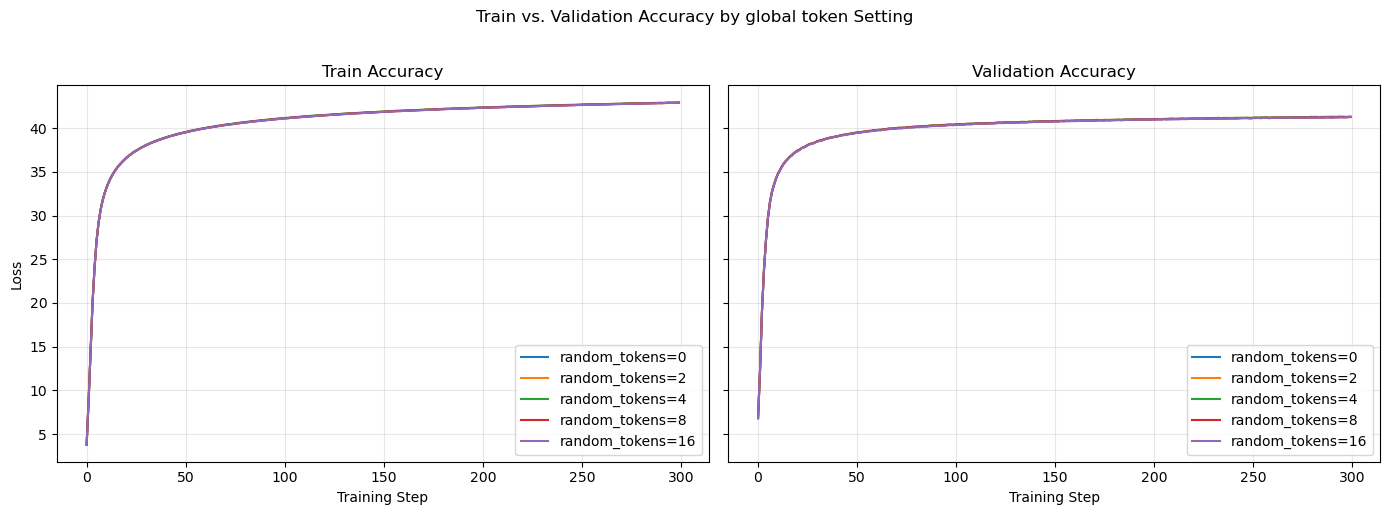

In [23]:
import matplotlib.pyplot as plt
import numpy as np
exp_values = sorted(train_losses['global'].unique())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=True)

# -------- Train Loss --------
ax = axes[0]
for exp in exp_values:
    data = train_losses[train_losses['global'] == exp]
    ax.plot(np.arange(len(data['accuracy'])),
            data['accuracy'],
            label=f'random_tokens={exp}')
ax.set_title('Train Accuracy')
ax.set_xlabel('Training Step')
ax.set_ylabel('Loss')
ax.grid(True, alpha=0.3)
ax.legend()

# -------- Validation Loss --------
ax = axes[1]
for exp in exp_values:
    data = val_losses[val_losses['global'] == exp]
    ax.plot(np.arange(len(data['accuracy'])),
            data['accuracy'],
            label=f'random_tokens={exp}')
ax.set_title('Validation Accuracy')
ax.set_xlabel('Training Step')
# sharey=True so no need to set ylabel again
ax.grid(True, alpha=0.3)
ax.legend()

plt.suptitle('Train vs. Validation Accuracy by global token Setting', y=1.02)
plt.tight_layout()
plt.show()

### BLEU Scores

## Attention Visualisation

In [26]:
from papers.CommonTransformerComponents.train_sp import build_model, get_encodings, get_dataloaders, model_prediction

In [28]:
import sentencepiece as spm
mh = {
'D_MODEL': 256,
'N_HEADS': 16,
'N_ENCODERS': 2, # 6
'N_DECODERS': 2, # 6
'FF_HIDDEN': 2048,
'DROPOUT': 0.1,
'SEQ_LEN': 140,
'TRAIN_RATIO' : 0.9,
'BATCH_SIZE': 128,
'GLOBAL_ATTENTION': 1,
'LOCAL_ATTENTION': 3,
'RANDOM_ATTENTION': 4
}
sp = spm.SentencePieceProcessor(model_file="../attention_is_all_you_need/BPE/en-hi.model")
model  = build_model(sp, "cpu", mh, "sparse")

In [30]:
from collections import OrderedDict

checkpoint = torch.load(
    f"Models/sparse/"
    f"hindi_model_"
    f"{mh['N_HEADS']}_"
    f"{mh['D_MODEL']}_"
    f"{mh['FF_HIDDEN']}_"
    f"{mh['N_DECODERS']}_"
    f"{mh['N_ENCODERS']}_"
    f"{mh['GLOBAL_ATTENTION']}_"
    f"{mh['LOCAL_ATTENTION']}_"
    f"{mh['RANDOM_ATTENTION']}/"
    "Model_300",
    map_location=torch.device("cpu")
)

checkpoint['model_state_dict'] = OrderedDict((k.replace("module.", ""), v) for k, v in checkpoint['model_state_dict'].items())
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [49]:
import torch
import numpy as np

class AttentionScoreHook:
    def __init__(self, model):
        self.model = model
        self.attention_scores = []
        self.queries = []
        self.keys = []
        self.hook_handles = []
        self.layer_count = 0
        self._register_hooks()
        
    def _make_hook(self, layer_idx):
        def hook(module, input, output):
            if hasattr(module, 'attention_scores'):
                if module.queries is not None and module.keys is not None:
                    self.attention_scores.append((layer_idx, module.attention_scores.detach().cpu().clone()))
                    self.queries.append((layer_idx, module.queries.detach().cpu().clone()))
                    self.keys.append((layer_idx, module.keys.detach().cpu().clone()))
        return hook
    
    def _register_hooks(self):
        """Register hooks on all MultiHeadAttention modules"""
        layer_idx = 0
        for encoder_layer in self.model.encoder.layers:
            handle = encoder_layer.attention.register_forward_hook(
                self._make_hook(layer_idx)
            )
            self.hook_handles.append(handle)
            layer_idx += 1
            self.layer_count += 1
            
        for decoder_layer in self.model.decoder.layers:
            # Self-attention
            handle = decoder_layer.attention.register_forward_hook(
                self._make_hook(layer_idx)
            )
            self.hook_handles.append(handle)
            layer_idx += 1
            self.layer_count += 1
            
            # Cross-attention
            handle = decoder_layer.attention_2.register_forward_hook(
                self._make_hook(layer_idx)
            )
            self.hook_handles.append(handle)
            layer_idx += 1
            self.layer_count += 1
    
    def get_attention_scores(self):
        """
        Get attention scores as [batch_size, num_layers, num_heads, seq_len, seq_len]
        
        Returns:
            Tuple of (attention_scores, queries, keys) each with shape 
            [batch_size, num_layers, num_heads, seq_len, seq_len] for attention_scores
            and appropriate shapes for queries and keys
        """
        sorted_scores = sorted(self.attention_scores, key=lambda x: x[0])
        sorted_queries = sorted(self.queries, key=lambda x: x[0])
        sorted_keys = sorted(self.keys, key=lambda x: x[0])
        
        results = []
        for sorted_tensor in [sorted_scores, sorted_queries, sorted_keys]:
            tensors = [tensor for _, tensor in sorted_tensor]
            
            # Stack along a new dimension (layer dimension)
            stacked = torch.stack(tensors, dim=0)  # [num_layers, batch, heads, seq_len, seq_len/dk/dk]
            
            # Transpose to get [batch_size, num_layers, num_heads, seq_len, seq_len/dk/dk]
            transposed = stacked.permute(1, 0, 2, 3, 4)
            result = transposed.numpy()
            results.append(result)
        
        self.attention_scores = []
        self.keys = []
        self.queries = []
        
        return results[0], results[1], results[2]
    
    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()
        self.hook_handles = []

def extract_attention_weights(model, src, tgt, src_masks=None, tgt_masks=None):
    """
    Extract attention weights from the model.
    
    Returns:
        Tuple of (attention_weights, queries, keys) each with shape 
        [batch_size, num_layers, num_heads, seq_len, seq_len] for attention_weights
    """
    hook = AttentionScoreHook(model)    
    with torch.inference_mode():
        model(src, tgt, src_masks, tgt_masks, return_attention=True)
    
    attention_weights, queries, keys = hook.get_attention_scores()
    hook.remove_hooks()
    
    return attention_weights, queries, keys

def get_token_until_eos(sentences):
    trimmed = []
    for tokens in sentences:
        if '<EOS>' in tokens:
            eos_idx = tokens.index('<EOS>')
            trimmed.append(tokens[: eos_idx + 1])
        else:
            trimmed.append(tokens)
    return trimmed

In [32]:
ee, he, sp = get_encodings("../../data/en-hi/", model_file="../attention_is_all_you_need/BPE/en-hi.model", nrows=100)
train_dataloader, test_dataloader = get_dataloaders(sp, ee, he, mh)

In [33]:
batch = next(iter(train_dataloader))
# split_encoded = sp.id_to_piece(converted_sentence['src'][0].tolist())
# split_decoded = sp.id_to_piece(pred.detach().cpu().tolist()[0])
# subsequent_mask = torch.tril(torch.ones((140, 140), dtype=torch.int))
# padding_mask = (pred != sp.pad_id()).int()
# decoder_mask = subsequent_mask & padding_mask
# attention_vals, query_vals, keys_vals = extract_attention_weights(model, converted_sentence['src'], pred, converted_sentence['encoder_mask'], decoder_mask.unsqueeze(0))
# split_encoded_trim = get_token_until_eos(split_encoded)
# split_decoded_trim = get_token_until_eos(split_decoded)

In [34]:
pred = model_prediction(model, batch, 140, "cpu", sp.bos_id(), sp.eos_id(), sp.pad_id())

In [50]:
subsequent_mask = torch.tril(torch.ones((140, 140), dtype=torch.int))
padding_mask = ((pred != sp.pad_id()).int()).unsqueeze(1)  # Add a dimension for the batch size
decoder_mask = subsequent_mask & padding_mask
attention_vals, query_vals, keys_vals = extract_attention_weights(model, batch['src'], pred, batch['encoder_mask'], decoder_mask.unsqueeze(1))
split_encoded = [sp.id_to_piece(s) for s in batch['src'].tolist()]
split_decoded = sp.id_to_piece(pred.detach().cpu().tolist()[0])
split_decoded = [sp.id_to_piece(s) for s in pred.detach().cpu().tolist()]
split_encoded_trim = get_token_until_eos(split_encoded)
split_decoded_trim = get_token_until_eos(split_decoded)


<Axes: >

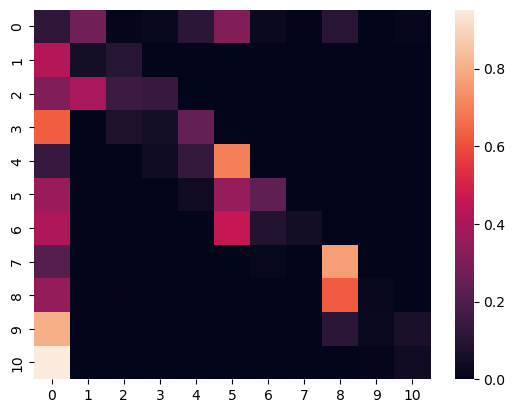

In [96]:
import seaborn as sns
sns.heatmap(attention_vals[idx, 0,8, :len(split_encoded_trim[idx]), :len(split_encoded_trim[idx])])

In [63]:
idx = 12
run_attention_dashboard(attention_vals[idx, ...], split_encoded_trim[idx], split_decoded_trim[idx], colormap='Viridis')

In [70]:
run_model_dashboard(attention_vals[idx, ...], split_encoded_trim[idx], split_decoded_trim[idx])

In [78]:
raw_attention = query_vals @ keys_vals.transpose(0, 1, 2, 4, 3)
run_neuron_dashboard(raw_attention[idx, ...], attention_vals[idx, ...], query_vals[idx, ...], keys_vals[idx, ...], 
                     split_encoded_trim[idx],  split_decoded_trim[idx])

NameError: name 'height' is not defined